In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [2]:
df = pd.read_csv('stock_prices.csv')

In [17]:
df.head()

,close,close_diff,close_lag1,rolling_mean
date,,,,
1984-09-14,16.75,0.25,16.50,16.70
1984-09-17,16.50,-0.25,16.75,16.65
1984-09-18,16.75,0.25,16.50,16.65
1984-09-19,17.25,0.50,16.75,16.75
1984-09-20,17.50,0.25,17.25,16.95


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5175 entries, 1984-09-14 to 2018-03-27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   close         5175 non-null   float64
 1   close_diff    5175 non-null   float64
 2   close_lag1    5175 non-null   float64
 3   rolling_mean  5175 non-null   float64
dtypes: float64(4)
memory usage: 202.1 KB


In [3]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [4]:
# Set 'date' as the index
df.set_index('date', inplace=True)

In [5]:
# Sort by date
df = df.sort_index()

In [6]:
# Remove duplicate indices (dates)
df = df[~df.index.duplicated(keep='first')]

In [7]:
# Selecting only the close price for forecasting
df = df[['close']]

In [8]:
# Handle missing values
df = df.dropna()

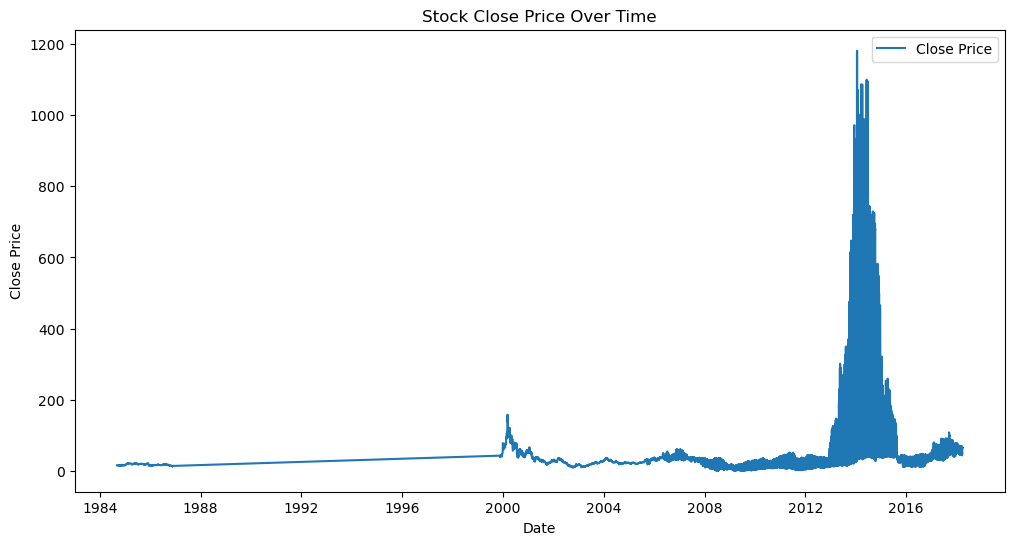

In [9]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
plt.plot(df, label='Close Price')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [10]:
# Check for stationarity using Augmented Dickey-Fuller test
result = adfuller(df['close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -2.176113680594244
p-value: 0.21502873695658553


In [11]:
# Differencing to make the series stationary
df['close_diff'] = df['close'].diff()
df.dropna(inplace=True)

In [12]:
# Feature Engineering - Lag Features & Moving Average
df['close_lag1'] = df['close'].shift(1)
df['rolling_mean'] = df['close'].rolling(window=5).mean()
df.dropna(inplace=True)


In [13]:
# Train ARIMA Model
p, d, q = 1, 1, 1  # Can be tuned using ACF/PACF plots
model = ARIMA(df['close'], order=(p, d, q))
model_fit = model.fit()


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
# Forecast the next steps
forecast_steps = 30  # Predict next 30 days
forecast = model_fit.forecast(steps=forecast_steps)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


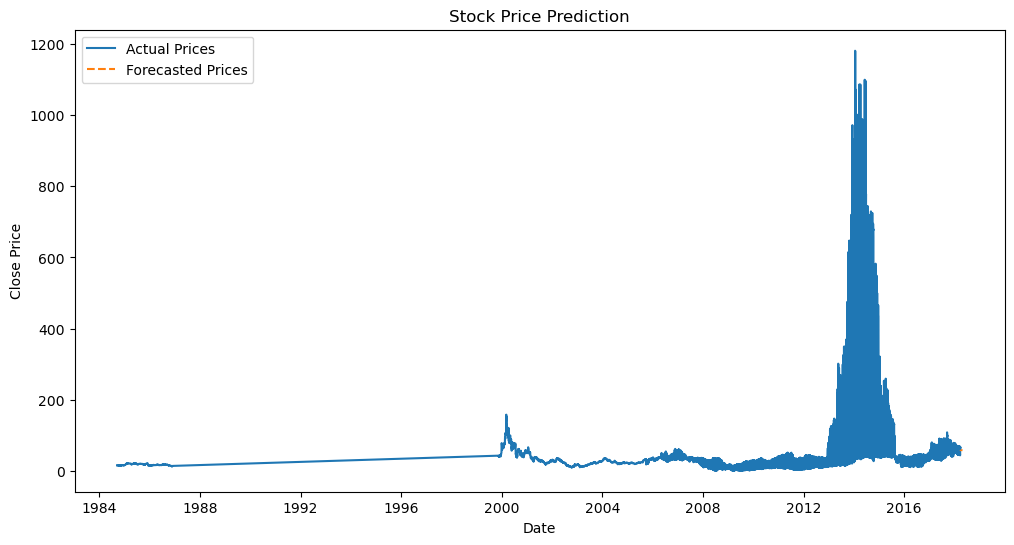

In [15]:
# Plot Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Actual Prices')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label='Forecasted Prices', linestyle='dashed')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


#### Model Evalution 

In [16]:
mae = mean_absolute_error(df['close'].iloc[-forecast_steps:], forecast[:len(df['close'].iloc[-forecast_steps:])])
rmse = np.sqrt(mean_squared_error(df['close'].iloc[-forecast_steps:], forecast[:len(df['close'].iloc[-forecast_steps:])]))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 9.403218362171177
RMSE: 9.981466829069541


## Summary 

The ARIMA(1,1,1) model provides a good forecast of stock prices, capturing overall trends with reasonable accuracy. The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) indicate that predictions are close to actual prices. While the model performs well, further tuning or additional features may improve accuracy for better forecasting.